# Análise de Clique Máximo

## Começando

### Dependências

In [59]:
!mkdir output
!pip install -r requirements.txt

mkdir: cannot create directory ‘output’: File exists


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import subprocess

from matplotlib import pyplot as plt

### Construindo grafos

A complexidade do algorítimo do clique máximo cresce conforme o tamanho da rede, que é medida na quantidade de arestas.

Dado um número de vértices e a densidade da rede, gera uma série de arquivos contendo as arestas de redes geradas aleatóriamente.

In [61]:
n_vertices = (5, 10, 20, 50, 75, 100, 120, 150, 200, 500, 1000, 2000, 4000, 8000, 10_000)
densities = (.3, .5, .7)

for n in n_vertices:
    for i, d in enumerate(densities):
        subprocess.call(["./utils/make-graph.py", str(n), str(d), "-o", f"output/graph-{n}-{i+1}.txt"])

KeyboardInterrupt: 

### Limpeza de arquivos

**Atenção!** Somente execute a próxima célula caso deseje limpar os arquivos de redes geradas anteriormente.

In [ ]:
!rm output/graph-*

### Visualização e checagem de cliques

Um clique é um grupo de vértices onde há a maior densidade de arestas. Para identificar isso, consideramos uma matriz quadrada de ordem $n$, onde $n$ é o número de vértices representados pela matriz. A submatriz correspondente, formada pelas linhas e colunas dessa matriz, deve estar completamente preenchida, exceto pela diagonal de identidade.

Para facilitar essa verificação, os seguintes programas ajudam a visualizar e checar um arquivo junto com a sequência de vértices do grafo. Estes programas auxiliam na identificação e validação de cliques.

In [122]:
!c++ -Ofast -Wall -pedantic utils/view-clique.cpp -o output/view-clique.out
!c++ -Ofast -Wall -pedantic utils/check-clique.cpp -o output/check-clique.out

In [4]:
def check(executable, filename, view = False):
    process = subprocess.run([executable, filename], capture_output=True, text=True)
    result = process.stdout.split("\n")[0]
    args = result.split(", ")

    if view:
        subprocess.call(["./output/view-clique.out", filename, *args])

    process = subprocess.run(["./output/check-clique.out", filename, *args], capture_output=True, text=True)
    result = process.stdout.split("\n")

    status = result[2].find("PASS") > 0
    size = int(result[1][10:])

    return status, size


## Abordagem exaustiva: Algoritmo de Bron-Kerbosch

A implementação da abordagem exaustiva seguiu o algoritmo de Born-Kerbosch apresentado pelo artigo de F. Cazals e C. Karande (2008). Este é um algorítmo de busca recursiva

In [33]:
!c++ -Ofast -Wall -pedantic src/main.cpp src/exaustive-bron-kerbosch.cpp -o output/exaustive-recursive.out

In [5]:
filename = "output/graph-120-3.txt"

In [34]:
subprocess.call(["./output/exaustive-recursive.out", filename])

27 35 38 41 47 51 54 66 79 86 94 108 109 112 114 119 

27, 35, 38, 41, 47, 51, 54, 66, 79, 86, 94, 108, 109, 112, 114, 119
Filename: output/graph-120-3.txt
Execution time: 93.6858 seconds


0

In [162]:
output = "27, 35, 38, 41, 47, 51, 54, 66, 79, 86, 94, 108, 109, 112, 114, 119"
args = output.split(", ")

subprocess.call(["./output/view-clique.out", filename, *args])
subprocess.call(["./output/check-clique.out", filename, *args])

 27  -    X X X X X X X X X X X X X X X 
 35  -  X   X X X X X X X X X X X X X X 
 38  -  X X   X X X X X X X X X X X X X 
 41  -  X X X   X X X X X X X X X X X X 
 47  -  X X X X   X X X X X X X X X X X 
 51  -  X X X X X   X X X X X X X X X X 
 54  -  X X X X X X   X X X X X X X X X 
 66  -  X X X X X X X   X X X X X X X X 
 79  -  X X X X X X X X   X X X X X X X 
 86  -  X X X X X X X X X   X X X X X X 
 94  -  X X X X X X X X X X   X X X X X 
108  -  X X X X X X X X X X X   X X X X 
109  -  X X X X X X X X X X X X   X X X 
112  -  X X X X X X X X X X X X X   X X 
114  -  X X X X X X X X X X X X X X   X 
119  -  X X X X X X X X X X X X X X X   
Filename: output/graph-120-3.txt
Size:     16
Status:   PASS

0

# Abordagem não exaustiva: Heuristica gulosa

Refletindo sobre o problma do Clique máximo, tive a impressão de não haver necessidade de buscar em grande profundidade para encontrar a resposta. Dado que o clique trata-se de um sub-conjunto comum entre linhas/colunas da matriz, a primeira impressão que tive foi que a intercessão entre as linhas do clique máximo deve ser o máximo global e similar entre eles. Para implementar este algoritmo, segui o seguinte pseudocódigo:

```txt
Cria um vetor de clique máximo

atribui valor 1 a diagonal de identidade da matriz

Para cada linha de um vértice da matriz:
    Cria uma lista de intercessões cujo:
        Vértice vizinho
        Valor de Degree, inicialmente nulo
        Resultado da intercessão entre a linha do vértice e as linhas de cada vértice vizinho

    Para cada combinação entre os vértices vizinhos:
        Obtém o vértice vizinho e seu maior grau de similaridade com outro vizinho
        Atualiza o valor de degree do respectivo vértice na lista de intercessões
    
    Ordena de modo decrescente a lista de intercessões conforme o valor de degree

    Cria vetor de clique do tamanho de uma linha da matriz preenchido com 1

    Para cada intercessão:
        Caso a coluna do vértice no vetor de clique seja 0:
            pula esta intercessão
        
        Caso contrário:
            Atualiza o vetor clique com a intercessão em operação lógica E
    
    Cria vetor de vértices

    Para cada coluna do vetor de clique:
        Caso a coluna seja 1:
            Adiciona ao vetor de vértices o índice da coluna
    
    Caso o vetor de vértices seja maior que o vetor de clique máximo:
        Atribui o vetor de clique máximo como o atual vetor de vértices

restaura a diagonal de identidade da matriz

Reporta o vetor de clique máximo como resposta
```

In [78]:
!c++ -Ofast -Wall -pedantic src/main.cpp src/heuristic-greedy-omp.cpp -o output/heuristic-greedy-omp.out

In [79]:
subprocess.call(["./output/heuristic-greedy-omp.out", filename])

27, 35, 38, 41, 47, 51, 54, 66, 79, 86, 94, 108, 109, 112, 114, 119
Filename: output/graph-120-3.txt
Execution time: 0.239632 seconds


0

In [80]:
check("./output/heuristic-greedy-omp.out", filename, True)

 27  -    X X X X X X X X X X X X X X X 
 35  -  X   X X X X X X X X X X X X X X 
 38  -  X X   X X X X X X X X X X X X X 
 41  -  X X X   X X X X X X X X X X X X 
 47  -  X X X X   X X X X X X X X X X X 
 51  -  X X X X X   X X X X X X X X X X 
 54  -  X X X X X X   X X X X X X X X X 
 66  -  X X X X X X X   X X X X X X X X 
 79  -  X X X X X X X X   X X X X X X X 
 86  -  X X X X X X X X X   X X X X X X 
 94  -  X X X X X X X X X X   X X X X X 
108  -  X X X X X X X X X X X   X X X X 
109  -  X X X X X X X X X X X X   X X X 
112  -  X X X X X X X X X X X X X   X X 
114  -  X X X X X X X X X X X X X X   X 
119  -  X X X X X X X X X X X X X X X   


(True, 16)

## Verificando os resultados

Executa as abordagens para cada grafo gerado.

In [31]:
import networkx as nx

with open(filename, 'r') as graphfile:
    next(graphfile)

    g = nx.parse_adjlist(graphfile)

pos = nx.kamada_kawai_layout(g)

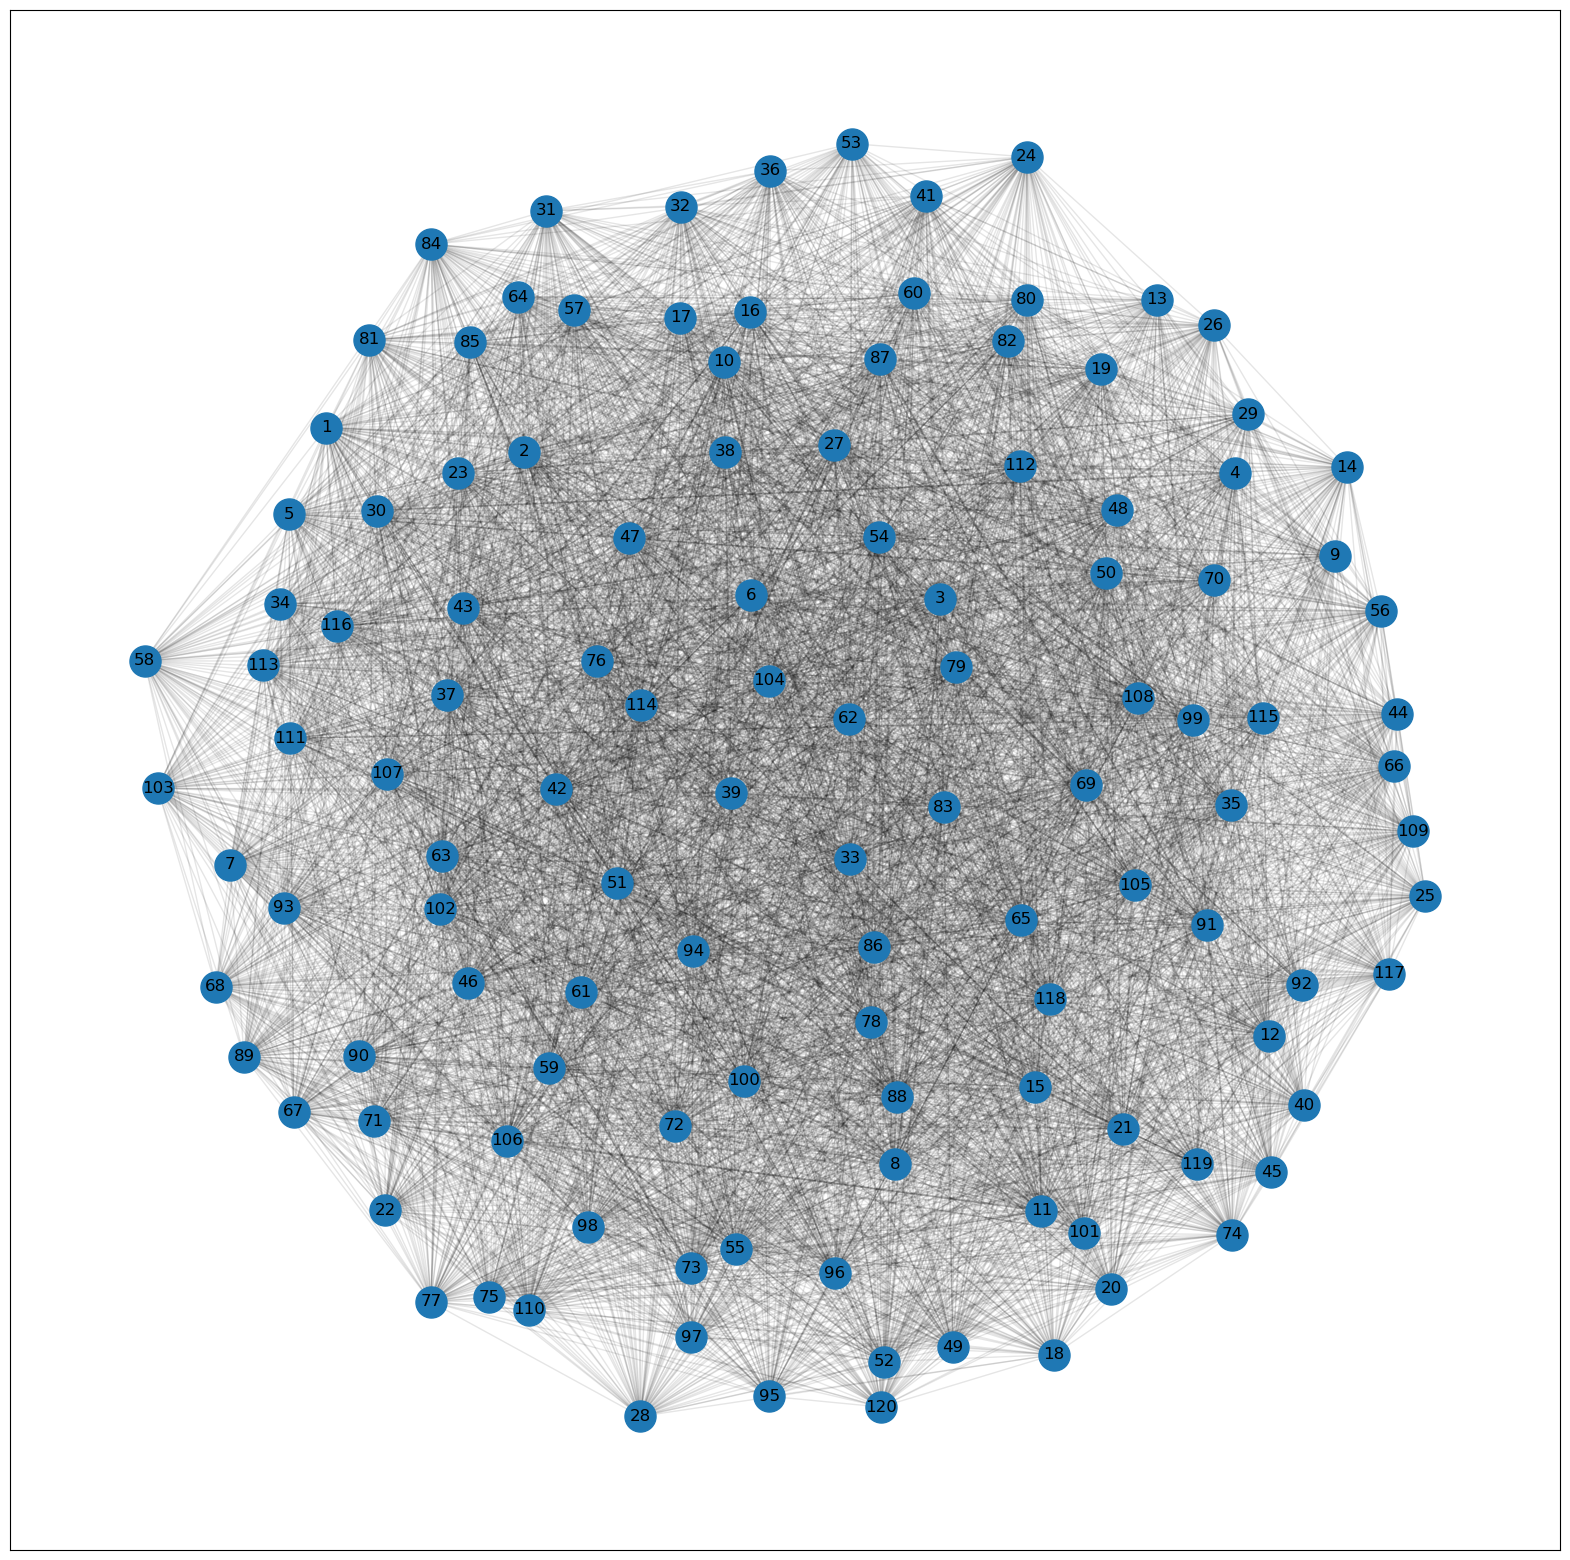

In [32]:
plt.figure(figsize=(20, 20))
# nx.draw(g, pos, alpha=0.05, with_labels=True, font_size=30)
nx.draw_networkx_nodes(g, pos, node_size=500, alpha=1.0)
nx.draw_networkx_edges(g, pos, alpha=0.1)
nx.draw_networkx_labels(g, pos)
plt.show()

In [ ]:
for n in n_vertices[:10]:
    for i in range(1, 4):
        subprocess.call(["./output/exaustive-recursive.out", f"output/graph-{n}-{i}.txt"])

In [ ]:
for n in n_vertices:
    for j in range(1, 4):
        subprocess.call(["./output/heuristic-greedy-omp.out", f"output/graph-{n}-{i+1}.txt"])

### Verificando cliques

In [ ]:
cliques = [
    ["2", "4", "5"],
    ["1", "3", "4"],
    ["1", "3"],
    ["4", "5", "7"],
    ["3", "4", "6", "10"],
    ["1", "2", "3", "4", "6"],
    ["1", "6", "12", "19"],
    ["2", "8", "12", "14", "18", "20"],
    ["4", "5", "7", "8", "12", "13", "17", "20"],
    ["5", "28", "31", "42", "49"],
    ["1", "6", "9", "10", "29", "30", "35"],
    ["2", "3", "10", "15", "17", "18", "24", "25", "27", "31", "35"],
    ["7", "11", "22", "48", "63", "64"],
    ["1", "13", "21", "32", "45", "49", "52", "58", "71"],
    ["2", "4", "7", "9", "17", "19", "21", "44", "48", "51", "58", "59", "63", "71"],
    ["1", "41", "52", "56", "57", "73"],
    ["2", "4", "8", "41", "45", "74", "75", "84", "87"],
    ["17", "21", "31", "38", "40", "42", "57", "58", "64", "67", "69", "73", "75", "83", "92"],
    ["1", "16", "34", "41", "67", "74"],
    ["6", "15", "26", "29", "30", "36", "59", "84", "97", "118"],
    ["2", "8", "10", "15", "31", "32", "35", "38", "44", "47", "57", "78", "99", "111", "120"],
    ["7", "31", "34", "83", "90", "128", "145"],
    ["7", "67", "84", "86", "94", "97", "106", "126", "138", "142"],
    ["2", "7", "12", "16", "20", "23", "32", "37", "67", "76", "88", "113", "132", "139", "144", "148"],
]

i = 0
for n in n_vertices[:8]:
    for j in range(1, 4):
        subprocess.call(["./output/check-clique.out", f"output/graph-{n}-{j}.txt", *cliques[i]])
        print()

        i += 1

In [ ]:
cliques = [
    ["2", "4", "5"],
    ["1", "3", "4"],
    ["1", "3"],
    ["4", "5", "7"],
    ["3", "4", "6", "10"],
    ["1", "2", "3", "4", "6"],
    ["1", "6", "12", "19"],
    ["2", "8", "12", "14", "18", "20"],
    ["5", "7", "8", "12", "13", "15", "17", "20"],
    ["6", "7", "18", "27", "48"],
    ["4", "9", "10", "11", "17", "23", "32"],
    ["2", "3", "10", "15", "17", "18", "24", "25", "27", "31", "35"],
    ["7", "11", "22", "48", "63", "64"],
    ["13", "21", "31", "32", "45", "52", "55", "64", "67"],
    ["2", "4", "17", "21", "22", "26", "44", "47", "49", "51", "63", "65", "71"],
    ["1", "41", "52", "56", "57", "73"],
    ["6", "8", "9", "41", "67", "78", "80", "84", "87"],
    ["2", "4", "10", "13", "16", "17", "21", "36", "46", "64", "69", "78", "85", "88"],
    ["4", "7", "17", "24", "40", "83"],
    ["6", "15", "26", "29", "30", "36", "59", "84", "97", "118"],
    ["7", "11", "13", "15", "24", "30", "33", "48", "52", "59", "62", "64", "98", "101"],
    ["7", "34", "60", "65", "128", "145", "146"],
    ["7", "67", "84", "86", "94", "97", "106", "126", "138", "142"],
    ["4", "10", "17", "27", "28", "31", "37", "40", "48", "52", "56", "71", "90", "110", "115", "127"],
    ["13", "70", "99", "132", "138", "144", "149"],
    ["1", "5", "33", "57", "83", "92", "104", "143", "161", "172", "174"],
    ["14", "19", "40", "48", "62", "84", "85", "86", "96", "124", "138", "147", "150", "177", "186", "194", "196"],
    ["21", "55", "121", "149", "157", "361", "421", "430", "462"],
    ["2", "30", "45", "66", "159", "171", "173", "188", "243", "328", "477", "486"],
    ["82", "127", "129", "145", "174", "200", "208", "234", "238", "274", "300", "305", "322", "373", "421", "438", "450", "455", "467", "499"],
    ["63", "123", "294", "362", "434", "446", "498", "707", "911"],
    ["24", "31", "223", "418", "439", "445", "569", "672", "743", "766", "770", "784", "806", "815"],
    ["4", "42", "75", "102", "119", "252", "272", "343", "364", "383", "450", "453", "526", "570", "609", "611", "660", "737", "807", "809", "820", "830", "997"]
]

i = 0
for n in n_vertices:
    for j in range(1, 4):
        subprocess.call(["./output/check-clique.out", f"output/graph-{n}-{j}.txt", *cliques[i]])
        print()

        i += 1

## Análise do tempo de execução

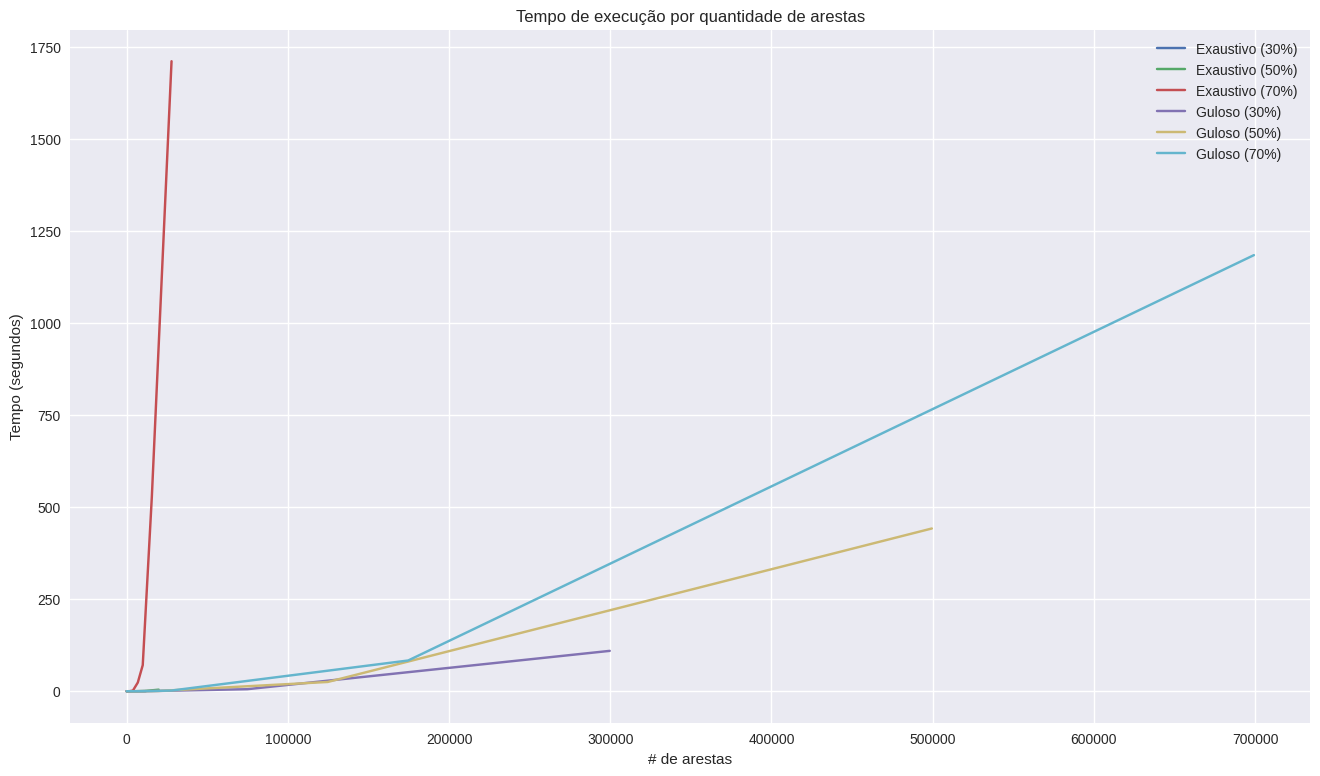

In [ ]:
exaustive_times = [
    [                   # 30%
        6.5e-06,
        1.81e-05,
        4.69e-05,
        0.0005088,
        0.0014128,
        0.004301,
        0.0052875,
        0.0143867,
        0.2026426,
    ], [                # 50%
        1.18e-05,
        2.84e-05,
        0.0001327,
        0.0054866,
        0.0260184,
        0.0901806,
        0.261848,
        0.624345,
        4.21486,
    ], [                # 70%
        9.7e-06,
        6.37e-05,
        0.000592,
        0.0962623,
        1.71182,
        23.614,
        70.7898,
        528.571,
        1710.21486,
    ]
]

heuristic_times = [
    [                 # 30%
        2.42e-05,
        1.8e-05,
        6.76e-05,
        0.0011064,
        0.0039671,
        0.0119158,
        0.0171206,
        0.0447335,
        0.153038,
        5.49881,
        109.556,
    ], [                # 50%
        6e-06,
        2.07e-05,
        0.0001302,
        0.0037844,
        0.013491,
        0.0330012,
        0.0630392,
        0.178818,
        0.66576,
        25.124,
        441.767,
    ], [                # 70%
        7.2e-06,
        3.35e-05,
        0.0002248,
        0.0048463,
        0.026808,
        0.094127,
        0.188273,
        0.559523,
        1.87388,
        83.4311,
        1183.84,
    ]
]

plt.style.use("seaborn")
plt.figure(figsize=(16, 9))
plt.title("Tempo de execução por quantidade de arestas")

for i, d in enumerate(densities):
    y = exaustive_times[i]
    x = [(n * (n-1)) * d for n in n_vertices[0:len(y)]]

    plt.plot(x, y, label=f"Exaustivo ({d*100:.0f}%)")

for i, d in enumerate(densities):
    y = heuristic_times[i]
    x = [(n * (n-1)) * d for n in n_vertices[0:len(y)]]

    plt.plot(x, y, label=f"Guloso ({d*100:.0f}%)")

plt.xlabel("# de arestas")
plt.ylabel("Tempo (segundos)")
plt.legend()
plt.show()

## Conclusão

Para a abordagem exaustiva, é possível observar um rápido crescimento no tempo de execução conforme o número de arestas na rede aumenta, dado pela densidade da rede. Isso sedá por conta do caráter exponencial do algorítimo de Bron-Kerbosch, de complexidade $O(3^{n/3})$. Já a abordagem gulosa consegue computar em redes bem maiores e densas com tempo de execução mais razoável. E embora não chegue na resposta correta na minioria dos casos, esta abordagem chega muito próximo do clique máximo global. As linhas no gráfico para cada abordagem e densidade devem ser similares com maiores quantidades de dados. Nos testes que realizei, obtive um acerto de cerca de 85%.

## Abordagem distribuída: Supercomputação!

A implementação do algorítimo em computção distribuída permite obter o melhor tempo de execução para um algorítimo com alta complexidade.

In [ ]:
!mpic++ -Ofast -Wall -pedantic -fopenmp src/main-mpi.cpp src/maximal-clique-mpi.cpp -o output/maximal-clique-mpi.out
!sbatch ./output/maximal-clique-mpi.out